In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from Functions import StatisticalAnalysis, amari

from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr,compare_nrmse
from skimage import data, img_as_float
from skimage.color import rgb2gray

from scipy import stats
from sklearn.decomposition import PCA, FastICA

audio = '/home/micael/Documents/Mestrado/base_audio_ica'
imagem = '/home/micael/Documents/Mestrado/base_imagens_ica'
save_imagem = '/home/micael/Documents/Mestrado/ICA/trabalho_parte2'


In [2]:
import scipy.misc as sm


In [3]:
x1 = sm.imread(imagem+'/'+'2_run'+'/'+'1_saida_r2.jpg',mode='RGB')
x2 = sm.imread(imagem+'/'+'2_run'+'/'+'2_saida_r2.jpg',mode='RGB')
x3 = sm.imread(imagem+'/'+'2_run'+'/'+'3_saida_r2.jpg',mode='RGB')

s1 = sm.imread(imagem+'/'+'2_run_key'+'/'+'Bored_face_1.jpg',mode='RGB')
s2 = sm.imread(imagem+'/'+'2_run_key'+'/'+'Bored_pose_1.jpg',mode='RGB')
s3 = sm.imread(imagem+'/'+'2_run_key'+'/'+'Cardboard_1.jpg',mode='RGB')

mixMatrix = np.loadtxt(imagem+'/'+'1_run_key'+'/'+'weights.txt',delimiter=',')

print x1.shape,x2.shape,s1.shape,s2.shape,mixMatrix

red_sources = [s1[:,:,0].flatten(),s2[:,:,0].flatten()]
green_sources = [s1[:,:,1].flatten(),s2[:,:,1].flatten()]
blue_sources = [s1[:,:,2].flatten(),s2[:,:,2].flatten()]

(400, 500, 3) (400, 500, 3) (400, 500, 3) (400, 500, 3) [[ 0.3  0.7]
 [ 0.4  0.6]]


In [10]:
red_recovered_sources = []
green_recovered_sources = []
blue_recovered_sources = []

numero_interacao = []
convergence_time = []

channels = ['red','green','blue']

for i in range(x1.shape[2]):
    x1_flatten = x1[:,:,i].flatten()
    x2_flatten = x2[:,:,i].flatten()
    x3_flatten = x3[:,:,i].flatten()
    X = np.vstack([x1_flatten,x2_flatten,x3_flatten])
    print '============',i,'===================='
    init_time = time.time()
    ica = FastICA(n_components=3,algorithm='parallel',whiten=True,fun='logcosh')
    fit = ica.fit(X.T)
    print 'number of interations:', fit.n_iter_ 
    y = ica.transform(X.T)

    current_time = time.time()
    print 'Time to converges the FastICA: %1.3f seconds'%(current_time-init_time)
    numero_interacao.append(fit.n_iter_)
    convergence_time.append(current_time-init_time)
    #print y.shape
    for j in range(y.shape[1]):
    #    y_source = np.reshape(y[:,j],(400,500))
        
        if i==0:
            xR = y[:,j].T
            red_recovered_sources.append((((xR-np.min(xR))/np.max(xR-np.min(xR)))* 255))
        elif i==1:
            xG = y[:,j].T
            green_recovered_sources.append((((xG-np.min(xG))/np.max(xG-np.min(xG)))* 255))
        else:
            xB = y[:,j].T
            blue_recovered_sources.append(((xB-np.min(xB))/np.max(xB-np.min(xB))*255))
    #   sm.imsave('recovered_source_channel_'+channels[i]+'_' + str(j) + '.png', y_source)

============ 0 ====================
number of interations: 5
Time to converges the FastICA: 0.264 seconds
============ 1 ====================
number of interations: 7
Time to converges the FastICA: 0.283 seconds
============ 2 ====================
number of interations: 8
Time to converges the FastICA: 0.308 seconds


In [11]:
numero_interacao = np.asarray(numero_interacao)
convergence_time = np.asarray(convergence_time)
means = np.reshape(np.array([np.sum(numero_interacao),np.sum(convergence_time)]),(1,2))
run1_info = np.vstack([numero_interacao,convergence_time])
run1_info = np.hstack([run1_info,means.T])
numero_interacao,convergence_time, run1_info, means.T

(array([5, 7, 8]),
 array([ 0.26371908,  0.28277397,  0.30779099]),
 array([[  5.        ,   7.        ,   8.        ,  20.        ],
        [  0.26371908,   0.28277397,   0.30779099,   0.85428405]]),
 array([[ 20.        ],
        [  0.85428405]]))

In [12]:
import pandas as pd

information_run1 = pd.DataFrame(run1_info)

print information_run1.to_latex()

\begin{tabular}{lrrrr}
\toprule
{} &         0 &         1 &         2 &          3 \\
\midrule
0 &  5.000000 &  7.000000 &  8.000000 &  20.000000 \\
1 &  0.263719 &  0.282774 &  0.307791 &   0.854284 \\
\bottomrule
\end{tabular}



In [7]:
len(red_recovered_sources)

2

In [27]:
names = ['imagem1','imagem2','imagem3']
sources = [s1,s2,s3]
image_similarity = np.zeros([len(sources),len(sources)])
for i in range(len(red_recovered_sources)):
    MI_g = [StatisticalAnalysis.calc_MI(red_recovered_sources[i],green_recovered_sources[j]) for j in range(len(green_recovered_sources))]
    MI_b = [StatisticalAnalysis.calc_MI(red_recovered_sources[i],blue_recovered_sources[j]) for j in range(len(blue_recovered_sources))]

    g_index = MI_g.index(max(MI_g))
    b_index = MI_b.index(max(MI_b))
    if i==0:
        y = np.zeros(x1.shape)
        y[:,:,0] =  -1*np.reshape(red_recovered_sources[i].T,(400,500))
        y[:,:,1] =  np.reshape(green_recovered_sources[g_index].T,(400,500))
        y[:,:,2] =  np.reshape(blue_recovered_sources[b_index].T,(400,500))
    
        y = y.astype('uint8')
        for j in range(len(sources)):
            image_similarity[j][i] = ssim(sources[j].astype('uint8'),y,multichannel=True)

    elif i==1:
        y = np.zeros(x1.shape)
        y[:,:,0] =  -1*np.reshape(red_recovered_sources[i].T,(400,500))
        y[:,:,1] = -1*np.reshape(green_recovered_sources[g_index].T,(400,500))
        y[:,:,2] =  np.reshape(blue_recovered_sources[b_index].T,(400,500))
    
        y = y.astype('uint8')
        for j in range(len(sources)):
            image_similarity[j][i] = ssim(sources[j].astype('uint8'),y,multichannel=True)

    else:
        y = np.zeros(x1.shape)
        y[:,:,0] =  -1*np.reshape(red_recovered_sources[i].T,(400,500))
        y[:,:,1] =  np.reshape(green_recovered_sources[g_index].T,(400,500))
        y[:,:,2] =  np.reshape(blue_recovered_sources[b_index].T,(400,500))
    
        y = y.astype('uint8')
        for j in range(len(sources)):
            image_similarity[j][i] = ssim(sources[j].astype('uint8'),y,multichannel=True)

    sm.imsave(save_imagem+'/'+'run2_extracted_'+names[i]+'.png',y)
image_similarity

array([[ 0.18434357,  0.11243815,  0.49414951],
       [ 0.47900327,  0.13850497,  0.2109116 ],
       [ 0.07991918,  0.81460099,  0.17082654]])

In [29]:
ordened_similarity = np.zeros_like(image_similarity)
ordened_similarity[:,0]=image_similarity[:,2]
ordened_similarity[:,1]=image_similarity[:,0]
ordened_similarity[:,2]=image_similarity[:,1]

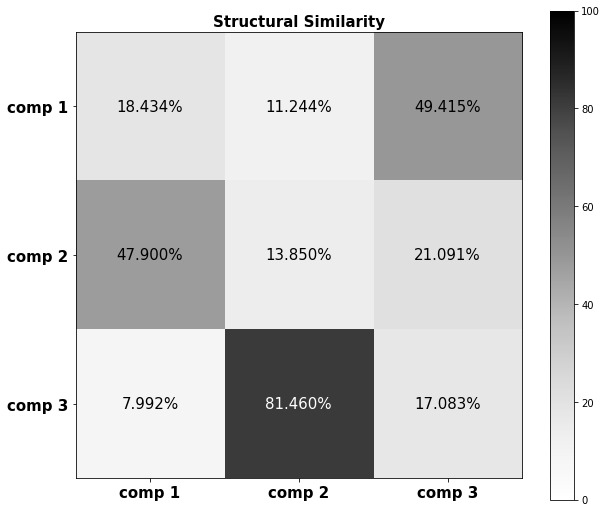

In [32]:
StatisticalAnalysis.plot_in_matrix(image_similarity,title='Structural Similarity',
                                   output=save_imagem,name='structural_similarity_run2',save=True)

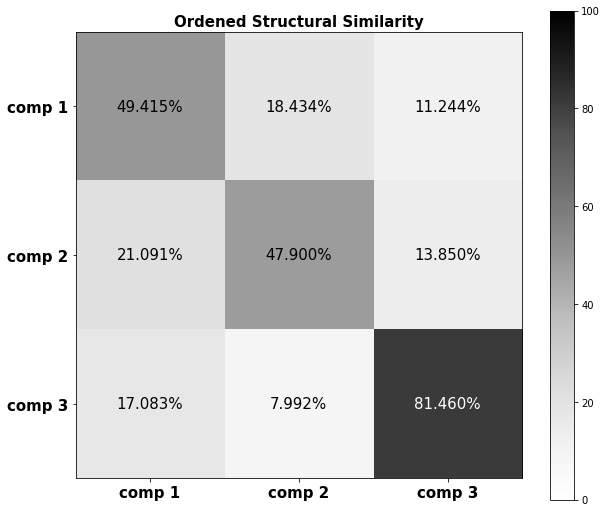

In [33]:
StatisticalAnalysis.plot_in_matrix(ordened_similarity,title='Ordened Structural Similarity',
                                   output=save_imagem,name='ordened_structural_similarity_run2',save=True)

In [7]:
for i in range(len(red_recovered_sources)):
    for j in range(len(red_sources)):
        print StatisticalAnalysis.calc_MI(red_recovered_sources[i],red_sources[j])

0.0203705342929
0.222514932041
0.173439081313
0.0072019635816


In [46]:
dog_tensor = np.zeros(x1.shape)
dog_tensor[:,:,0] = red_recovered_sources[1]
dog_tensor[:,:,1] = green_recovered_sources[1]
dog_tensor[:,:,2] = blue_recovered_sources[0]

In [47]:
sm.imsave('dog_tensor.png',dog_tensor)

In [50]:
horse_tensor = np.zeros(x1.shape)
horse_tensor[:,:,0] = red_recovered_sources[0]
horse_tensor[:,:,1] = green_recovered_sources[0]
horse_tensor[:,:,2] = blue_recovered_sources[1]

In [51]:
sm.imsave('horse_tensor.png',horse_tensor)